# Goldman Sachs Warsaw Quant Challenge

After many experiments and research I decided to use data augmentation. This solution takes the original training dataset and augment it in order to obtain thousands of examples where either offered price is much bigger than a "threshold" selling price or much smaller than the "threshold". Labels are 'true' and 'false respectively.

### Table of contents:
1. [Data Exploration](#section_1)
   1. [Load Data](#section_1_1)
   2. [Data Distribution](#section_1_2)
   3. [Pandas-profiling](#section_1_3)
2. [Data Preprocessing](#section_2)
   1. [Remove Duplicate Rows](#section_2_1)
   2. [Tokenize Countries](#section_2_1)
   3. [Data Augmentation](#section_2_1)
   4. [Extract mean and standard deviation](#section_2_1)
   5. [Create train and cross-validation sets](#section_2_1)
3. [DNN Model](#section_3)
   1. [Normalization Layer](#section_3_1)
   2. [Model Definition](#section_3_2)
   3. [Brier Skill Score - metric and loss](#section_3_3)
   4. [Train](#section_3_4)
      + [Model 1 - reLu + RMSprop](#section_3_4_1)
      + [Model 2 - reLu + Adam](#section_3_4_2)
      + [Model 3 - tanh + RMSprop](#section_3_4_3)
      + [Model 4 - tanh + Adam](#section_3_4_4)
   5. [Evaluate and test](#section_3_5)
   6. [Summary](#section_3_6)
   7. [Check Monotonicity](#section_3_7)
4. [Submission](#section_4)
   1. [Load Test Data](#section_4_1)
   2. [Tokenize Countries](#section_4_2)
   3. [Predict and Save](#section_4_3)
5. [Histogram Gradient Boosting (additional solution)]()

### imports 

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.activations import relu, tanh


## 1. Data Exploration <a class="anchor" id="section_1"></a>

### 1.1. Load Data <a class="anchor" id="section_1_1"></a>

In [28]:
trainingDataFrame = pd.read_csv('train_final.csv')
trainingDataFrame.head()

,Won,Price,Coupon,Notional,Maturity,Sensitivity,Liquidity,Complexity,ParticipantCount,Country
0,False,173.989506,36.619581,7190.303746,5801.393623,12.861949,-11,30.331649,74,ITALY
1,False,154.434297,-14.493572,3907.754648,3117.677959,6.632008,0,26.388674,75,GERMANY
2,True,140.306546,-5.156848,1748.478438,1390.654047,1.066665,3,13.911858,73,FRANCE
3,False,136.185397,36.380886,2876.694033,2325.175004,-10.913600,4,-1.299865,100,NETHERLANDS
4,False,122.707273,1.697044,2097.140765,1690.196841,9.976876,5,-24.816807,69,FRANCE


### 1.2. Data Distribution <a class="anchor" id="section_1_2"></a>

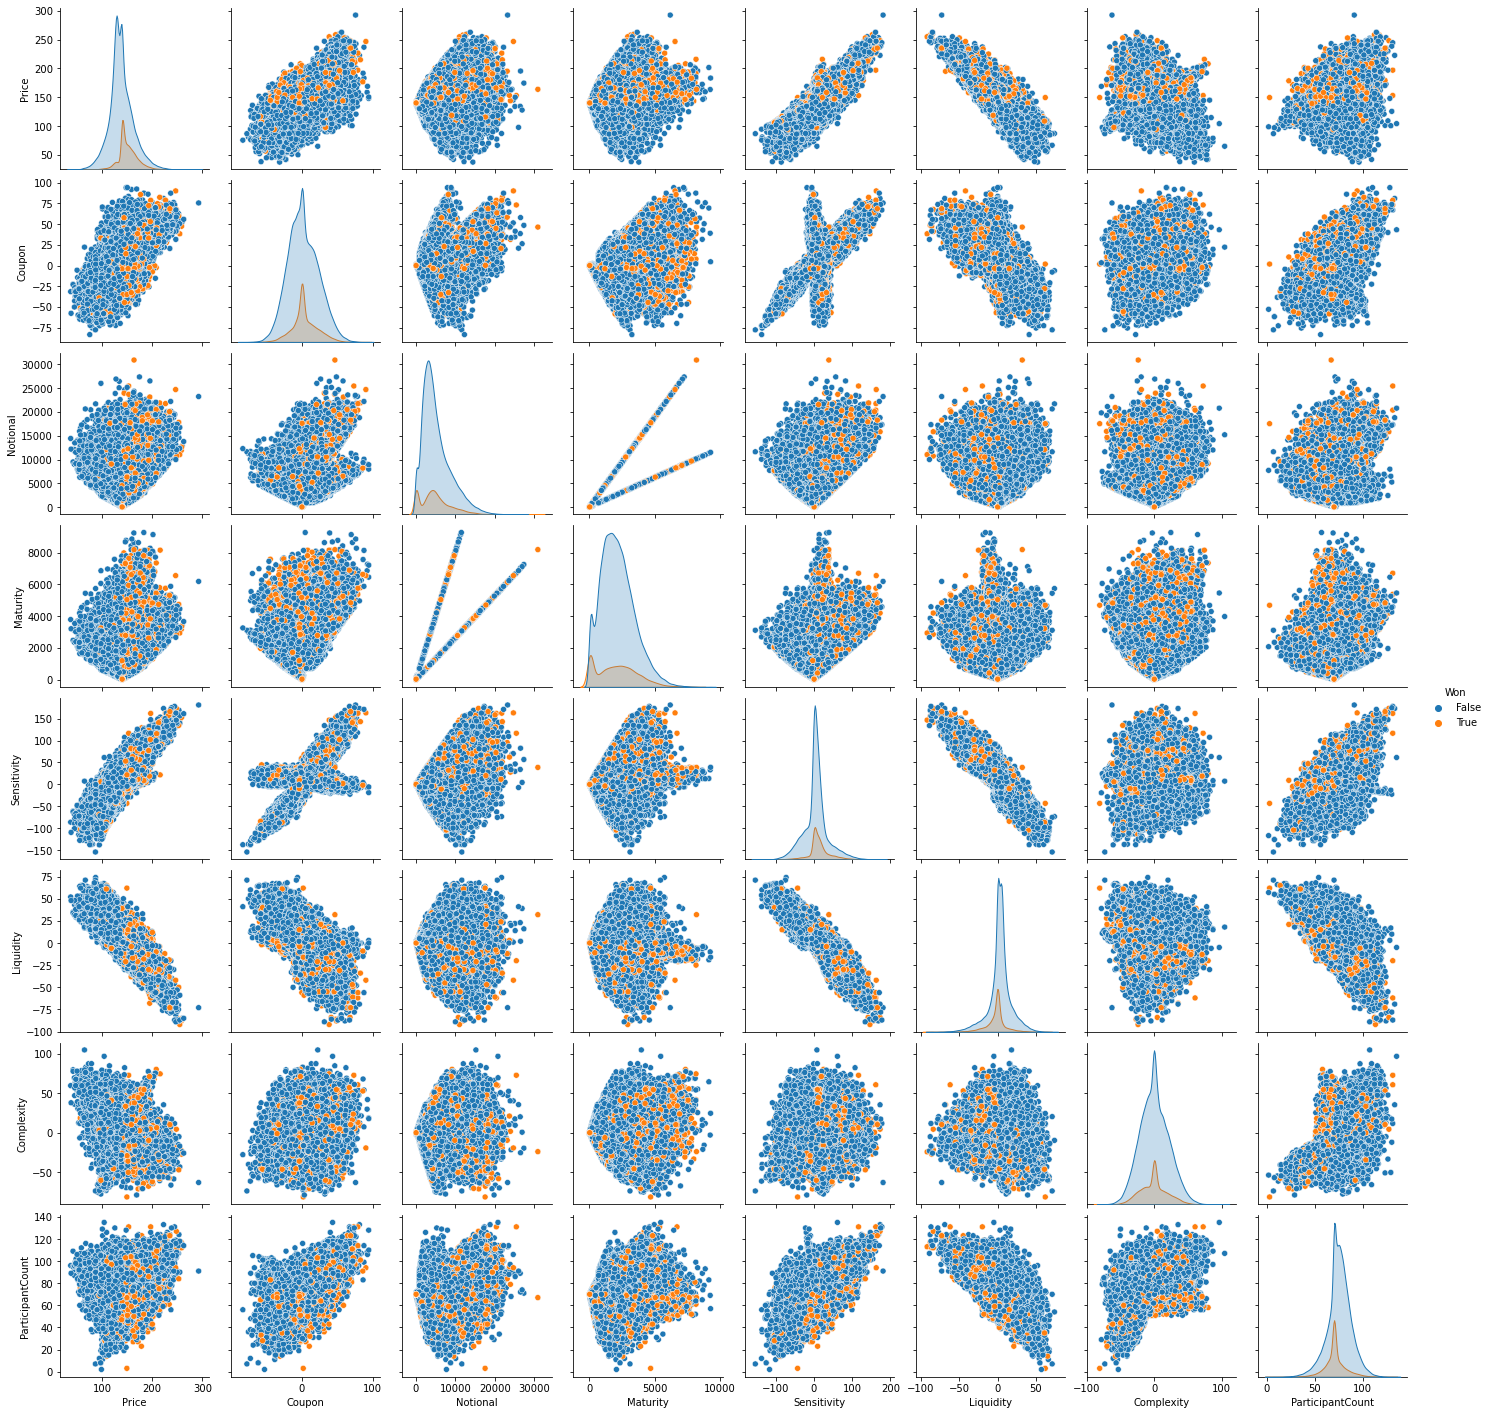

In [126]:
ax = sns.pairplot(trainingDataFrame, hue="Won")


### 1.3. Pandas-profiling <a class="anchor" id="section_1_3"></a>



This tool lets see lots of info about data without coding tens of matplotlib plots. We read that this dataset is highly correlated and has duplicate rows.

Open the `data_report.html` with your browser.

In [ ]:
!pip install --upgrade pandas-profiling

In [43]:
from pandas_profiling import ProfileReport
prof = ProfileReport(trainingDataFrame)
prof.to_file(output_file='data_report.html')

Summarize dataset:  62%|██████▏   | 13/21 [00:01<00:00, 13.52it/s, Calculate kendall correlation]    /home/matined/anaconda3/envs/quant/lib/python3.9/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 133.64it/s]


## 2. Data preprocessing <a class="anchor" id="section_2"></a>

### 2.1. Remove Duplicate Rows <a class="anchor" id="section_2_1"></a>

In [29]:
trainingDataFrame.drop_duplicates(keep=False, inplace=True)

### 2.2. Tokenize Countries <a class="anchor" id="section_2_2"></a>

In [30]:
tokenizer = Tokenizer(num_words=10, lower=False)
tokenizer.fit_on_texts(trainingDataFrame['Country'])
trainingDataFrame['Country'] = np.squeeze(tokenizer.texts_to_sequences(trainingDataFrame['Country']))
trainingDataFrame.head()


,Won,Price,Coupon,Notional,Maturity,Sensitivity,Liquidity,Complexity,ParticipantCount,Country
0,False,173.989506,36.619581,7190.303746,5801.393623,12.861949,-11,30.331649,74,1
1,False,154.434297,-14.493572,3907.754648,3117.677959,6.632008,0,26.388674,75,2
2,True,140.306546,-5.156848,1748.478438,1390.654047,1.066665,3,13.911858,73,3
3,False,136.185397,36.380886,2876.694033,2325.175004,-10.913600,4,-1.299865,100,6
4,False,122.707273,1.697044,2097.140765,1690.196841,9.976876,5,-24.816807,69,3


### 2.3. Data Augmentation <a class="anchor" id="section_2_3"></a>

Data is skewed. Moreover, we want a model to learn that prices higher than selling price are good as well.

In [31]:
trainingDataFrame['Won'].value_counts()

False    75501
True     14168
Name: Won, dtype: int64

In [32]:
true_examples_1 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
true_examples_2 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
true_examples_3 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
true_examples_4 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
true_examples_5 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
#true_examples_6 = trainingDataFrame.loc[trainingDataFrame['Won'] == True]
false_examples_1 = trainingDataFrame.loc[trainingDataFrame['Won'] == False]

random_add_1 = np.random.rand(true_examples_1.shape[0]) * 40
random_add_2 = np.random.rand(true_examples_1.shape[0]) * 60
random_add_3 = np.random.rand(true_examples_1.shape[0]) * 100
random_add_4 = np.random.rand(true_examples_1.shape[0]) * 200
random_add_5 = np.random.rand(true_examples_1.shape[0]) * 400
#random_add_6 = np.random.rand(true_examples_1.shape[0]) * 700

random_subtract_1 = np.random.rand(false_examples_1.shape[0]) * 40


true_examples_1['Price'] += random_add_1
true_examples_2['Price'] += random_add_2
true_examples_3['Price'] += random_add_3
true_examples_4['Price'] += random_add_4
true_examples_5['Price'] += random_add_5
false_examples_1['Price'] -= random_subtract_1

trainingDataFrame =  trainingDataFrame.append(true_examples_1, ignore_index=True)
trainingDataFrame =  trainingDataFrame.append(true_examples_2, ignore_index=True)
trainingDataFrame =  trainingDataFrame.append(true_examples_3, ignore_index=True)
trainingDataFrame =  trainingDataFrame.append(true_examples_4, ignore_index=True)
trainingDataFrame =  trainingDataFrame.append(true_examples_5, ignore_index=True)
#trainingDataFrame =  trainingDataFrame.append(true_examples_6, ignore_index=True)
trainingDataFrame =  trainingDataFrame.append(false_examples_1, ignore_index=True)


/tmp/ipykernel_10193/1234251422.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_examples_1['Price'] += random_add_1
/tmp/ipykernel_10193/1234251422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_examples_2['Price'] += random_add_2
/tmp/ipykernel_10193/1234251422.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [33]:
trainingDataFrame['Won'].value_counts()

False    151002
True      85008
Name: Won, dtype: int64

### 2.4. Extract mean and standard deviation for each feature <a class="anchor" id="section_2_4"></a>

In [6]:
mean = np.array(trainingDataFrame.drop(columns=['Won']).mean())
std = np.array(trainingDataFrame.drop(columns=['Won']).std())


### 2.5. Create train and cross-validation sets <a class="anchor" id="section_2_5"></a>

In [34]:
X = np.array(trainingDataFrame.drop(columns=['Won']))
y = np.array(trainingDataFrame['Won'], dtype='float')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


## 3. DNN Model <a class="anchor" id="section_3"></a>

### 3.1. Normalization layer <a class="anchor" id="section_3_1"></a>

In [11]:
class StandardScore(tf.keras.layers.Layer):
    def __init__(self, mean, std):
        super(StandardScore, self).__init__()
        self.mean = mean
        self.std = std

    def call(self, inputs):
        return (inputs - self.mean) / self.std


### 3.2. Model definition <a class="anchor" id="section_3_2"></a>

In [12]:
class AuctionModel(tf.keras.models.Model):
    def __init__(self, activation):
        super(AuctionModel, self).__init__()
        self.dense1 = Dense(32, activation=activation)
        self.dense2 = Dense(32, activation=activation)
        self.dense3 = Dense(32, activation=activation)
        self.dense4 = Dense(16, activation=activation)
        self.dense5 = Dense(16, activation=activation)
        self.dense6 = Dense(8, activation=activation)
        self.dense7 = Dense(1, activation='sigmoid')

        self.batchNorm1 = BatchNormalization()
        self.batchNorm2 = BatchNormalization()
        self.normalize = StandardScore(mean, std)

    
    def call(self, inputs):
        x = self.normalize(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.batchNorm1(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.batchNorm2(x)
        x = self.dense6(x)
        x = self.dense7(x)
        
        return x


### 3.3. Brier Score - metric and loss <a class="anchor" id="section_3_3"></a>

In [14]:
class BrierScore(tf.keras.metrics.Metric):
    def __init__(self):
        super(BrierScore, self).__init__()
        self.score = self.add_weight(name='score', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        number_of_examples = len(y_pred)

        self.score = tf.reduce_sum(tf.square(y_pred - y_true)) / float(number_of_examples)

    def result(self):
        return self.score


In [15]:
class BrierScoreLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(BrierScoreLoss, self).__init__()
    
    def call(self, y_true, y_pred):
        number_of_examples = len(y_pred)
        return tf.reduce_sum(tf.square(y_pred - y_true)) / float(number_of_examples)

### 3.4. Train <a class="anchor" id="section_3_4"></a>

#### 3.4.1 **Relu** Activation and **RMSprop** Optimizer <a class="anchor" id="section_3_4_1"></a>

In [16]:
model1 = AuctionModel(activation=relu)
model1.compile(loss=BrierScoreLoss(),
               optimizer=tf.keras.optimizers.RMSprop(),
               metrics=[Precision(), Recall(), BrierScore()])

2022-03-16 19:54:10.786949: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-16 19:54:10.787727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 19:54:10.788846: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
history = model1.fit(X_train, y_train, epochs=20, batch_size=256)
plt.plot(history.history['loss'])

2022-03-16 19:54:12.124449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-16 19:54:12.148939: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/20
738/738 [==============================] - 14s 16ms/step - loss: 0.1153 - precision: 0.7627 - recall: 0.7984 - brier_score: 0.0805
Epoch 2/20
738/738 [==============================] - 10s 14ms/step - loss: 0.0585 - precision: 0.9578 - recall: 0.8088 - brier_score: 0.0580
Epoch 3/20
738/738 [==============================] - 20s 28ms/step - loss: 0.0558 - precision: 0.9677 - recall: 0.8149 - brier_score: 0.0553
Epoch 4/20
738/738 [==============================] - 21s 28ms/step - loss: 0.0538 - precision: 0.9647 - recall: 0.8243 - brier_score: 0.0536
Epoch 5/20
738/738 [==============================] - 19s 26ms/step - loss: 0.0531 - precision: 0.9710 - recall: 0.8243 - brier_score: 0.0527
Epoch 6/20
738/738 [==============================] - 17s 23ms/step - loss: 0.0521 - precision: 0.9689 - recall: 0.8274 - brier_score: 0.0522
Epoch 7/20
738/738 [==============================] - 13s 18ms/step - loss: 0.0512 - precision: 0.9717 - recall: 0.8286 - brier_score: 0.0513
Epoch 

#### 3.4.2 **Relu** Activation and **Adam** Optimizer <a class="anchor" id="section_3_4_2"></a>

In [55]:
model2 = AuctionModel(activation=relu)
model2.compile(loss=BrierScoreLoss(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[Precision(), Recall(), BrierScore()])

Epoch 1/20
738/738 [==============================] - 11s 13ms/step - loss: 0.1105 - precision_3: 0.8046 - recall_3: 0.7477 - brier_score_3: 0.0786
Epoch 2/20
738/738 [==============================] - 11s 15ms/step - loss: 0.0580 - precision_3: 0.9481 - recall_3: 0.8215 - brier_score_3: 0.0571
Epoch 3/20
738/738 [==============================] - 15s 20ms/step - loss: 0.0548 - precision_3: 0.9587 - recall_3: 0.8240 - brier_score_3: 0.0546
Epoch 4/20
738/738 [==============================] - 18s 24ms/step - loss: 0.0535 - precision_3: 0.9649 - recall_3: 0.8264 - brier_score_3: 0.0528
Epoch 5/20
738/738 [==============================] - 18s 24ms/step - loss: 0.0516 - precision_3: 0.9710 - recall_3: 0.8308 - brier_score_3: 0.0520
Epoch 6/20
738/738 [==============================] - 12s 16ms/step - loss: 0.0516 - precision_3: 0.9698 - recall_3: 0.8293 - brier_score_3: 0.0515
Epoch 7/20
738/738 [==============================] - 10s 14ms/step - loss: 0.0516 - precision_3: 0.9735 - recal

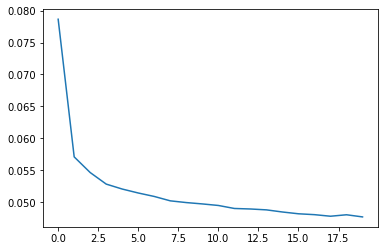

In [56]:
history = model2.fit(X_train, y_train, epochs=20, batch_size=256)
plt.plot(history.history['loss'])

#### 3.4.3 **Tanh** Activation and **RMSprop** Optimizer <a class="anchor" id="section_3_4_3"></a>

In [59]:
model3 = AuctionModel(activation=tanh)
model3.compile(loss=BrierScoreLoss(),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[Precision(), Recall(), BrierScore()])

Epoch 1/20
738/738 [==============================] - 12s 13ms/step - loss: 0.0902 - precision_5: 0.8547 - recall_5: 0.7885 - brier_score_5: 0.0719
Epoch 2/20
738/738 [==============================] - 11s 15ms/step - loss: 0.0611 - precision_5: 0.9360 - recall_5: 0.8190 - brier_score_5: 0.0597
Epoch 3/20
738/738 [==============================] - 16s 21ms/step - loss: 0.0568 - precision_5: 0.9504 - recall_5: 0.8239 - brier_score_5: 0.0567
Epoch 4/20
738/738 [==============================] - 13s 17ms/step - loss: 0.0559 - precision_5: 0.9579 - recall_5: 0.8249 - brier_score_5: 0.0546
Epoch 5/20
738/738 [==============================] - 11s 15ms/step - loss: 0.0540 - precision_5: 0.9617 - recall_5: 0.8265 - brier_score_5: 0.0532
Epoch 6/20
738/738 [==============================] - 12s 16ms/step - loss: 0.0523 - precision_5: 0.9627 - recall_5: 0.8318 - brier_score_5: 0.0521
Epoch 7/20
738/738 [==============================] - 14s 19ms/step - loss: 0.0509 - precision_5: 0.9682 - recal

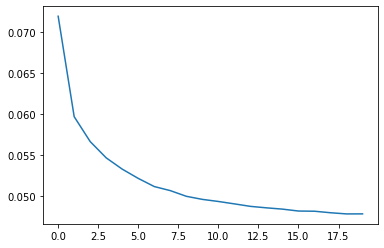

In [60]:
history = model3.fit(X_train, y_train, epochs=20, batch_size=256)
plt.plot(history.history['loss'])

#### 3.4.4 **Tanh** Activation and **Adam** Optimizer <a class="anchor" id="section_3_4_4"></a>

In [40]:
model4 = AuctionModel(activation=tanh)
model4.compile(loss=BrierScoreLoss(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[Precision(), Recall(), BrierScore()])

Epoch 1/20
738/738 [==============================] - 22s 30ms/step - loss: 0.0636 - precision_1: 0.9404 - recall_1: 0.8088 - brier_score_1: 0.0497
Epoch 2/20
738/738 [==============================] - 25s 34ms/step - loss: 0.0585 - precision_1: 0.9502 - recall_1: 0.8182 - brier_score_1: 0.0447
Epoch 3/20
738/738 [==============================] - 36s 49ms/step - loss: 0.0557 - precision_1: 0.9585 - recall_1: 0.8243 - brier_score_1: 0.0595
Epoch 4/20
738/738 [==============================] - 36s 48ms/step - loss: 0.0546 - precision_1: 0.9619 - recall_1: 0.8256 - brier_score_1: 0.0359
Epoch 5/20
738/738 [==============================] - 32s 43ms/step - loss: 0.0536 - precision_1: 0.9646 - recall_1: 0.8269 - brier_score_1: 0.0730
Epoch 6/20
738/738 [==============================] - 27s 36ms/step - loss: 0.0521 - precision_1: 0.9686 - recall_1: 0.8305 - brier_score_1: 0.0752
Epoch 7/20
738/738 [==============================] - 38s 51ms/step - loss: 0.0516 - precision_1: 0.9706 - recal

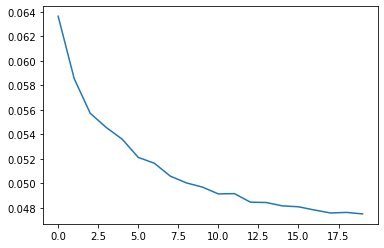

In [42]:
history = model4.fit(X_train, y_train, epochs=20, batch_size=256)
plt.plot(history.history['loss'])

### 3.5. Evaluate and test <a class="anchor" id="section_3_5"></a>

In [28]:
model1.evaluate(X_valid, y_valid)

1476/1476 [==============================] - 10s 6ms/step - loss: 0.0468 - precision: 0.9770 - recall: 0.8452 - brier_score: 9.1142e-06


[0.046757593750953674,
 0.9770262837409973,
 0.8452248573303223,
 9.114181011682376e-06]

In [64]:
model2.evaluate(X_valid, y_valid)

1476/1476 [==============================] - 7s 5ms/step - loss: 0.0508 - precision_3: 0.9952 - recall_3: 0.8114 - brier_score_3: 1.0950e-05


[0.050786640495061874,
 0.9952497482299805,
 0.8113595247268677,
 1.0949678653560113e-05]

In [65]:
model3.evaluate(X_valid, y_valid)

1476/1476 [==============================] - 8s 5ms/step - loss: 0.0495 - precision_5: 0.9771 - recall_5: 0.8315 - brier_score_5: 1.0838e-04


[0.04953208565711975,
 0.9771097898483276,
 0.8315437436103821,
 0.00010837586160050705]

In [66]:
model4.evaluate(X_valid, y_valid)

1476/1476 [==============================] - 7s 4ms/step - loss: 0.0531 - precision_6: 0.9391 - recall_6: 0.8546 - brier_score_6: 8.1733e-05


[0.053121283650398254,
 0.9390715956687927,
 0.8546030521392822,
 8.173250535037369e-05]

### 3.6 Summary <a class="anchor" id="section_3_6"></a>

Each model was trained for 10 epochs.

| model 	| activation 	| optimizer 	| training loss 	| test loss 	|
|:-----:	|:----------:	|:---------:	|:-------------:	|:---------:	|
|   1   	|    relu    	|  RMSprop  	|     0.0484    	|   0.0498  	|
|   2   	|    relu    	|    Adam   	|     0.0483    	|   0.0508  	|
|   3   	|    tanh    	|  RMSprop  	|     0.0479    	|   0.0495  	|
|   4   	|    tanh    	|    Adam   	|     0.0471    	|   0.0531  	|

**Note that:** Values may vary depending on the training.

### 3.7 Check Monotonicity <a class="anchor" id="section_3_7"></a>

Take a positive example from a cross-validation set and check how prediction changes when we check it for price from 0 through 350.

In [33]:
predictions = []
prices = list(range(0, 351, 5))
for price in prices:    # 0, 5, 10, ..., 350
    pred = model1.predict(np.array([[price, -3.98007213e+00,  3.90689718e+03,  3.12995277e+03,
                                     8.29174933e+00, -3.00000000e+00,  2.44770629e+01,  7.10000000e+01,
                                     2.00000000e+00]]))
    predictions.append(np.squeeze(pred))

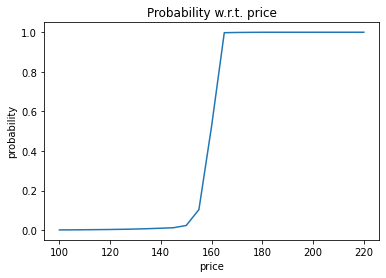

In [38]:
%matplotlib inline

plt.xlabel('price')
plt.ylabel('probability')
plt.title('Probability w.r.t. price')
plt.plot(prices[20:45], predictions[20:45])

## 4. Submission <a class="anchor" id="section_4"></a>

### 4.1. Load Test Data <a class="anchor" id="section_4_1"></a>

In [67]:
test_data = pd.read_csv('test_final.csv')
test_data.head()

,Price,Coupon,Notional,Maturity,Sensitivity,Liquidity,Complexity,ParticipantCount,Country
0,110.953080,-32.485046,5350.658940,1436.489276,-77.171353,44,-38.714659,26,ITALY
1,140.850376,0.440454,72.040632,72.585150,1.559459,0,-0.234735,70,GERMANY
2,157.958941,6.978652,7775.279188,2067.585552,11.133403,3,-22.302563,63,ITALY
3,135.223870,16.524465,4745.298698,3832.112845,15.156011,0,-20.855772,71,GERMANY
4,105.645099,-11.955790,5088.156163,1332.633665,-26.440183,13,22.576246,81,AUSTRIA


### 4.2. Tokenize Countries <a class="anchor" id="section_4_2"></a>

In [68]:
test_data['Country'] = np.squeeze(tokenizer.texts_to_sequences(test_data['Country']))
test_data.head()

,Price,Coupon,Notional,Maturity,Sensitivity,Liquidity,Complexity,ParticipantCount,Country
0,110.953080,-32.485046,5350.658940,1436.489276,-77.171353,44,-38.714659,26,1
1,140.850376,0.440454,72.040632,72.585150,1.559459,0,-0.234735,70,2
2,157.958941,6.978652,7775.279188,2067.585552,11.133403,3,-22.302563,63,1
3,135.223870,16.524465,4745.298698,3832.112845,15.156011,0,-20.855772,71,2
4,105.645099,-11.955790,5088.156163,1332.633665,-26.440183,13,22.576246,81,7


### 4.3. Predict and save <a class="anchor" id="section_4_3"></a>

In [69]:
predictions = model1.predict(np.array(test_data))

In [70]:
np.savetxt("mateusz_nedzi_submission.csv", predictions, delimiter=",")

## 5. Histogram Gradient Boosting

### imports

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

### 5.1. Load, preprocess and normalize data

In [55]:
dataFrameGradient = pd.read_csv('train_final.csv')
dataFrameGradient.drop_duplicates(keep=False, inplace=True)

tokenizer = Tokenizer(num_words=10, lower=False)
tokenizer.fit_on_texts(dataFrameGradient['Country'])
dataFrameGradient['Country'] = np.squeeze(tokenizer.texts_to_sequences(dataFrameGradient['Country']))
dataFrameGradient.head()

mean = np.array(dataFrameGradient.drop(columns=['Won']).mean())
std = np.array(dataFrameGradient.drop(columns=['Won']).std())

X_grad = np.array(trainingDataFrame.drop(columns=['Won']))
y_grad = np.array(trainingDataFrame['Won'], dtype='float')

X_grad = (X_grad - mean) / std

X_grad_train, X_grad_valid, y_grad_train, y_grad_valid = train_test_split(X, y, test_size=0.2)



### 5.2 Define and train the model

In [57]:
gradientBoostingModel = HistGradientBoostingClassifier(max_bins=255, max_iter=100)

In [58]:
gradientBoostingModel.fit(X_grad_train, y_grad_train)

HistGradientBoostingClassifier()

In [59]:
gradientBoostingModel.score(X_grad_valid, y_grad_valid)

0.9286682767679335

In [60]:
gradientBoostingModel.predict_proba((np.array([[165, -3.98007213e+00,  3.90689718e+03,  3.12995277e+03,
                                     8.29174933e+00, -3.00000000e+00,  2.44770629e+01,  7.10000000e+01,
                                     2.00000000e+00]]) - mean) / std)[0, 1]

0.0015476880915903995

In [61]:
predictions = []
prices = list(range(0, 351, 5))
for price in prices:    # 0, 5, 10, ..., 350
    pred = gradientBoostingModel.predict_proba((np.array([[165, -3.98007213e+00,  3.90689718e+03,  3.12995277e+03,
                                     8.29174933e+00, -3.00000000e+00,  2.44770629e+01,  7.10000000e+01,
                                     2.00000000e+00]]) - mean) / std)
    predictions.append(np.squeeze(pred[0, 1]))

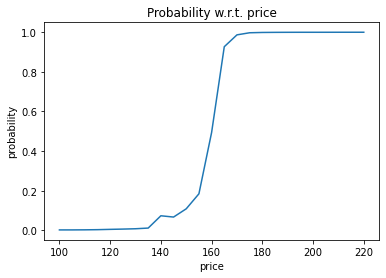

In [62]:
%matplotlib inline

plt.xlabel('price')
plt.ylabel('probability')
plt.title('Probability w.r.t. price')
plt.plot(prices[20:45], predictions[20:45])